In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, 
    LeakyReLU, Activation, 
    Concatenate, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow_addons.layers.normalizations import InstanceNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# define hardcoded values used throughout this notebook
IMAGE_SIZE = (512, 512)
IMAGE_SHAPE = (512, 512, 3)
DATASET_PATH = "/kaggle/input/tooth-motion-blurr/xray2_combined_20"
TRAIN_DIR = DATASET_PATH + "/training/"
VAL_DIR = DATASET_PATH + "/validation/"
NBR_EPOCHS = 20
BATCH_SIZE = 3
MAX_TRAIN_SAMPLES = 200  # restricts training data to this many samples - use for testing and for limited resources

In [3]:
# get the file names in each directory, and count how many files there are

def only_images(ls):
    return [f for f in ls if f.endswith('.jpg')]

train_files = os.listdir(TRAIN_DIR)
val_files = os.listdir(VAL_DIR)

train_files = only_images(train_files)
val_files = only_images(val_files)

train_files = [TRAIN_DIR + "/" + file_path for file_path in train_files]
val_files = [VAL_DIR + "/" + file_path for file_path in val_files]

print(f"{len(train_files)} training files")
print(f"{len(val_files)} validation files")

154 training files
39 validation files


Shape: (512, 1024, 3)
Pixel Value Range: 0 255
Shape: (512, 1024, 3)
Pixel Value Range: 11 235
Shape: (512, 1024, 3)
Pixel Value Range: 8 255
Shape: (512, 1024, 3)
Pixel Value Range: 2 255
Shape: (512, 1024, 3)
Pixel Value Range: 0 209
Shape: (512, 1024, 3)
Pixel Value Range: 9 255
Shape: (512, 1024, 3)
Pixel Value Range: 0 214
Shape: (512, 1024, 3)
Pixel Value Range: 1 255
Shape: (512, 1024, 3)
Pixel Value Range: 14 222
Shape: (512, 1024, 3)
Pixel Value Range: 16 255


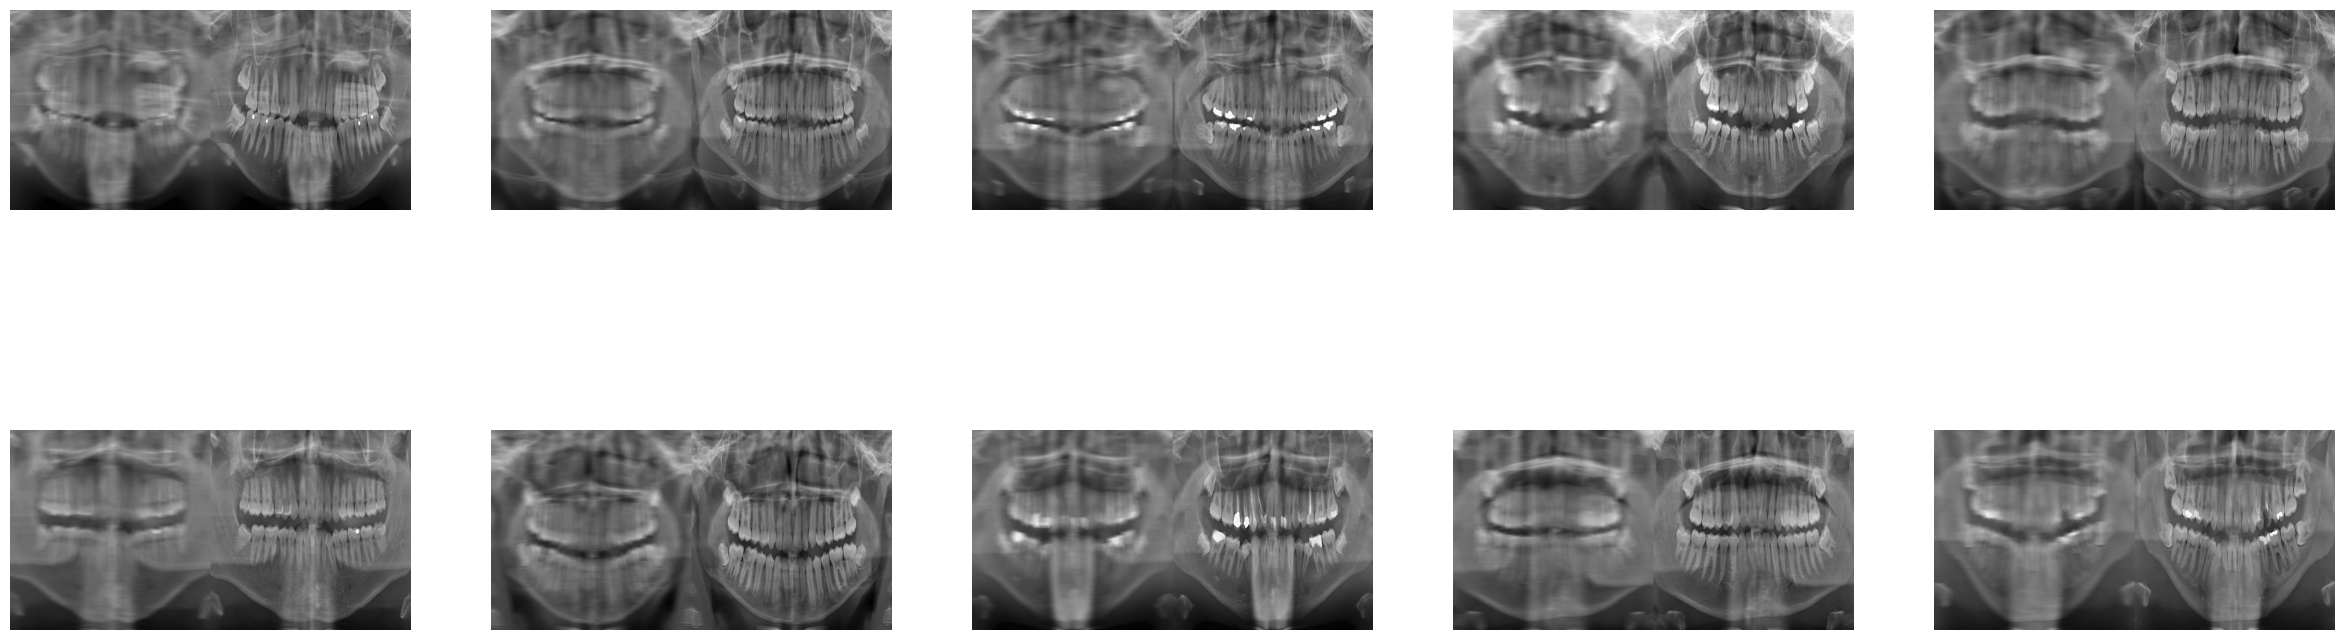

In [4]:
# show the pixel dimensions and value ranges of the first 10 training samples
sample_images = []
for i in train_files[:10]:
    img = cv2.imread(i)
    print("Shape:", img.shape)
    print("Pixel Value Range:", np.min(img), np.max(img))
    sample_images.append(img)
    
# visually inspect the images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
for idx, img in enumerate(sample_images):
    axs[idx//5, idx%5].imshow(img, cmap='gray')
    axs[idx//5, idx%5].axis('off')
plt.show()

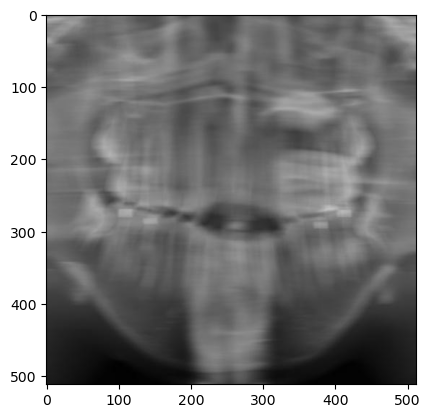

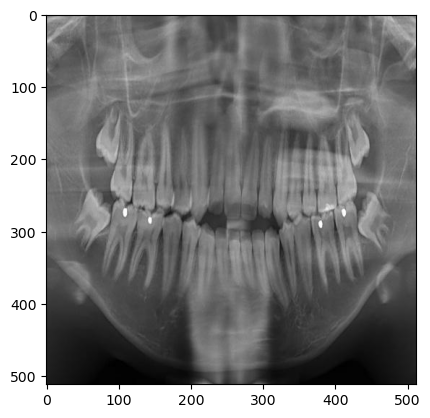

In [5]:
# ensure that edges and image are separable at pixel 256 in the x-dimension
sample0_edges, sample0_shoe = sample_images[0][:, :512], sample_images[0][:, 512:]
plt.imshow(sample0_edges)
plt.show()
plt.imshow(sample0_shoe)
plt.show()

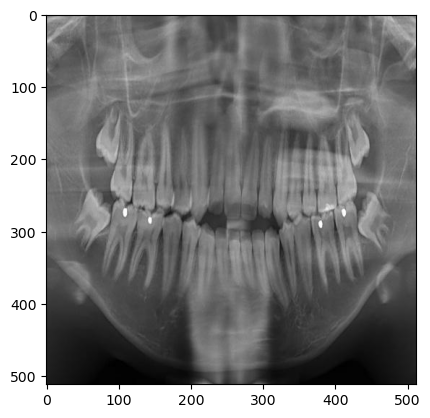

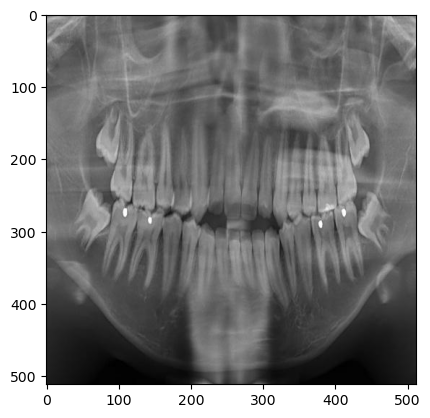

In [6]:
def resize_image(img, size):
    # get the image's original height and width
    h, w = img.shape[:2]
    
    # get the image's original number of color channels
    c = img.shape[2] if len(img.shape) > 2 else 1

    # If the image is square already, simply resize it.
    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)
    else:
        # find the longer dimension
        longer_dim = h if h > w else w

        # Determine which interpolation method to use.  If the longer 
        if longer_dim > (size[0] + size[1]) // 2:
            interpolation_method = cv2.INTER_AREA
        else:
            interpolation_method = cv2.INTER_CUBIC

        # get the coordinates of the original image
        x_pos = (longer_dim - w)//2
        y_pos = (longer_dim - h)//2

        # create an image of zeros, then copy the original
        #   image into position
        if len(img.shape) == 2:
            mask = np.zeros((longer_dim, longer_dim), dtype=img.dtype)
            mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
        else:
            mask = np.zeros((longer_dim, longer_dim, c), dtype=img.dtype)
            mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

        return cv2.resize(mask, size, interpolation_method)


# test the resizing function on a single image
img = cv2.imread(train_files[0])[:, 512:]
new_img = resize_image(img=img, size=IMAGE_SIZE)
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(new_img, cmap='gray')
plt.show()

In [7]:
class DataLoader():
    def __init__(self, dataset_folder_path, img_size):
        """
        Constructs a DataLoader object
        
        :params:
            dataset_folder_path (str): The path to the folder of 
                images to be loaded.  This is the name of the Pix2Pix dataset, 
                like edges2shoes.
            image_shape (tuple): Tuple of the image dimensions like (x, y).
        """
        self.dataset_folder_path = dataset_folder_path
        self.img_size = img_size
        self.nbr_batches = None

    def load_data(self, batch_size=1, use_for_training=True):
        """
        Loads data
        """
        if use_for_training:
            image_folder_path = self.dataset_folder_path + "/training"
        else:
            image_folder_path = self.dataset_folder_path + "/validation"
        
        # get a list of the files in the given path
        image_files = os.listdir(image_folder_path)
        image_files = [image_folder_path + "/" + i for i in image_files]
        if MAX_TRAIN_SAMPLES is not None:
            image_files = image_files[:MAX_TRAIN_SAMPLES]

        # randomly sample batch_size number of images from the given path
        batch_images = np.random.choice(image_files, size=batch_size)

        source_images = []
        target_images = []
        
        for img_path in batch_images:
            img = cv2.imread(img_path)
            
            # split the source from the target image at the pixel in the 
            #   width dimension that is 1/2 the total width (that's just 
            #   the way the images were created)
            h, w, channels = img.shape
            half_w = int(w/2)
            source_img = img[:, :half_w, :]
            target_img = img[:, half_w:, :]
            
            # resize images
            source_img = resize_image(source_img, self.img_size)
            target_img = resize_image(target_img, self.img_size)

            # if training, randomly flip 1/2 the images
            if use_for_training and np.random.random() < 0.5:
                source_img = np.fliplr(source_img)
                target_img = np.fliplr(target_img)

            source_images.append(source_img)
            target_images.append(target_img)

        # stack the batch images into a numpy array and scale pixels 
        #   to range from -1 to 1
        source_images = np.array(source_images)/127.5 - 1.
        target_images = np.array(target_images)/127.5 - 1.

        return source_images, target_images

    def load_batch(self, batch_size=1, use_for_training=True):
        """
        A batch load generator
        """
        if use_for_training:
            image_folder_path = self.dataset_folder_path + "/training"
        else:
            image_folder_path = self.dataset_folder_path + "/validation"

        # get a list of the files in the given path
        image_files = os.listdir(image_folder_path)
        image_files = [image_folder_path + "/" + i for i in image_files]
        if MAX_TRAIN_SAMPLES is not None:
            image_files = image_files[:MAX_TRAIN_SAMPLES]
        
        # determine how many batches, based on the number of files 
        #   and the batch size
        self.nbr_batches = int(len(image_files) / batch_size)

        for i in range(self.nbr_batches-1):
            batch = image_files[i*batch_size:(i+1)*batch_size]

            source_images = []
            target_images = []
            
            for img in batch:
                img = cv2.imread(img)
                
                # split the source from the target image at the pixel in the 
                #   width dimension that is 1/2 the total width (that's just 
                #   the way the images were created)
                h, w, channels = img.shape
                half_w = int(w/2)
                source_img = img[:, :half_w, :]
                target_img = img[:, half_w:, :]

                # resize images
                source_img = resize_image(source_img, self.img_size)
                target_img = resize_image(target_img, self.img_size)

                # if training, randomly flip 1/2 the images
                if use_for_training and np.random.random() < 0.5:
                    source_img = np.fliplr(source_img)
                    target_img = np.fliplr(target_img)

                source_images.append(source_img)
                target_images.append(target_img)

            # stack the batch images into a numpy array and scale pixels 
            #   to range from -1 to 1
            source_images = np.array(source_images)/127.5 - 1.
            target_images = np.array(target_images)/127.5 - 1.
            
            yield source_images, target_images


# test the data loader on a single image
loader = DataLoader(
    dataset_folder_path=DATASET_PATH,
    img_size=IMAGE_SIZE
)
train_source, train_target = loader.load_data(batch_size=1, use_for_training=True)
train_source.shape

(1, 512, 512, 3)

In [8]:
# test the data loader on a batch
loader = DataLoader(
    dataset_folder_path=DATASET_PATH,
    img_size=IMAGE_SIZE
)
for batch_nbr, batch in enumerate(loader.load_batch(batch_size=10, use_for_training=False)):
    print('batch nbr', batch_nbr, batch[0].shape, batch[1].shape)

batch nbr 0 (10, 512, 512, 3) (10, 512, 512, 3)
batch nbr 1 (10, 512, 512, 3) (10, 512, 512, 3)


In [9]:
def load_real_samples(batch_size, nbr_patches):
    loader = DataLoader(
        dataset_folder_path=DATASET_PATH,
        img_size=IMAGE_SIZE
    )
    real_source_images, real_target_images = loader.load_data(
        batch_size=batch_size,
        use_for_training=True
    )
    y = np.ones((len(real_source_images), nbr_patches, nbr_patches, 1))
    return [real_source_images, real_target_images], y



def generate_fake_samples(generator, real_source_image_samples, nbr_patches):
    fake_target_images = generator.predict(real_source_image_samples)
    y = np.zeros((len(fake_target_images), nbr_patches, nbr_patches, 1))
    return fake_target_images, y

In [10]:
class Pix2Pix:
    def __init__(self, input_image_shape):
        self.image_shape = input_image_shape
        self.data_loader = DataLoader(
            dataset_folder_path=DATASET_PATH,
            img_size=input_image_shape[:2]
        )
        # attributes that are defined by methods
        self.discriminator = None
        self.generator = None
        self.discriminator_nbr_patches = None
        self.gan = None

    def _build_discriminator(self):
        initial_weights = RandomNormal(stddev=0.02)

        source_image = Input(shape=self.image_shape)
        target_image = Input(shape=self.image_shape)

        combined_images = Concatenate()([source_image, target_image])

        # C64
        x = Conv2D(
            filters=64, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(combined_images)
        x = LeakyReLU(alpha=0.2)(x)
        # C128
        x = Conv2D(
            filters=128, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        # C256
        x = Conv2D(
            filters=256, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        # C512
        x = Conv2D(
            filters=512, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        # second last output layer
        x = Conv2D(
            filters=512, kernel_size=(4, 4),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        # patch output
        x = Conv2D(
            filters=1, kernel_size=(4, 4),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        patch_out = Activation('sigmoid')(x)
        # define model
        model = Model([source_image, target_image], patch_out)
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(
            loss='binary_crossentropy',
            optimizer=opt,
            loss_weights=[0.5]
        )

        return model

    @staticmethod
    def encoder_block(layer_in, nbr_filters, batch_norm=True):
        initial_weights = RandomNormal(stddev=0.02)

        # downsampling layer
        x = Conv2D(
            filters=nbr_filters, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(layer_in)

        if batch_norm:
            x = BatchNormalization()(x, training=True)

        x = LeakyReLU(alpha=0.2)(x)

        return x

    @staticmethod
    def decoder_block(layer_in, skip_in, nbr_filters, dropout=True):
        initial_weights = RandomNormal(stddev=0.02)

        # add upsampling layer
        x = Conv2DTranspose(
            filters=nbr_filters, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(layer_in)

        # add batch normalization
        x = BatchNormalization()(x, training=True)

        # conditionally add dropout
        if dropout:
            x = Dropout(0.5)(x, training=True)

        # merge with skip connection
        x = Concatenate()([x, skip_in])

        # relu activation
        x = Activation('relu')(x)

        return x

    def _build_generator(self):
        initial_weights = RandomNormal(stddev=0.02)

        input_image = Input(shape=self.image_shape)

        # encoder model
        e1 = Pix2Pix.encoder_block(
            layer_in=input_image,
            nbr_filters=64,
            batch_norm=False
        )
        e2 = Pix2Pix.encoder_block(e1, 128)
        e3 = Pix2Pix.encoder_block(e2, 256)
        e4 = Pix2Pix.encoder_block(e3, 512)
        e5 = Pix2Pix.encoder_block(e4, 512)
        e6 = Pix2Pix.encoder_block(e5, 512)
        e7 = Pix2Pix.encoder_block(e6, 512)

        # bottleneck layer
        b = Conv2D(
            filters=512, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(e7)
        b = Activation('relu')(b)

        # decoder model
        d1 = Pix2Pix.decoder_block(
            layer_in=b,
            skip_in=e7,
            nbr_filters=512,
            dropout=True
        )
        d2 = Pix2Pix.decoder_block(d1, e6, 512)
        d3 = Pix2Pix.decoder_block(d2, e5, 512)
        d4 = Pix2Pix.decoder_block(d3, e4, 512, dropout=False)
        d5 = Pix2Pix.decoder_block(d4, e3, 256, dropout=False)
        d6 = Pix2Pix.decoder_block(d5, e2, 128, dropout=False)
        d7 = Pix2Pix.decoder_block(d6, e1, 64, dropout=False)

        # output
        x = Conv2DTranspose(
            filters=3, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(d7)
        output_image = Activation('tanh')(x)

        # define model
        model = Model(input_image, output_image)

        return model

    def _build_gan(self):
        source_image = Input(shape=self.image_shape)

        # build discriminator and generator
        self.discriminator = self._build_discriminator()
        self.generator = self._build_generator()

        # store the discriminator output number of patches
        self.discriminator_nbr_patches = self.discriminator.output_shape[1]

        # freeze discriminator weights for this combined model
        self.discriminator.trainable = False

        # map inputs and outputs
        generator_output = self.generator(source_image)
        discriminator_output = self.discriminator([source_image, generator_output])

        # model takes source image as input,
        # produces generated image and real/fake prediction as output
        model = Model(source_image, [discriminator_output, generator_output])

        model.compile(
            loss=['binary_crossentropy', 'mae'],
            optimizer=Adam(lr=0.0002, beta_1=0.5),
            loss_weights=[1, 100]
        )

        return model
    
    def save_samples(self, epoch, batch_i):
        os.makedirs('generated_images/', exist_ok=True)
        r, c = 3, 3
        
        # load source and target images, and generate a fake image
        source_imgs, target_imgs = self.data_loader.load_data(batch_size=3, use_for_training=False)
        fake_imgs = self.generator.predict(target_imgs)
        
        # combine them and rescale them to range from 0 to 1
        gen_imgs = np.concatenate([target_imgs, fake_imgs, source_imgs])
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("generated_images/%d_%d.png" % (epoch, batch_i))
        plt.close()

    def train(self, nbr_epochs, batch_size, sample_interval=100):
        # build the GAN
        self.gan = self._build_gan()
        
        for epoch in range(nbr_epochs):

            print("Epoch", epoch, "of", nbr_epochs)
            d_loss_real_hist, d_loss_fake_hist, g_loss_hist = [], [], []

            for batch_i, (x_real_source, x_real_target) in enumerate(
                self.data_loader.load_batch(batch_size)
            ):
                # create corresponding real labels
                y_real = np.ones((
                    len(x_real_source), 
                    self.discriminator_nbr_patches,
                    self.discriminator_nbr_patches,
                    1
                ))
                
                # generate a batch of fake samples
                x_fake_target, y_fake = generate_fake_samples(
                    generator=self.generator, 
                    real_source_image_samples=x_real_source, 
                    nbr_patches=self.discriminator_nbr_patches
                )
                
                # update discriminator for real samples
                d_loss_real = self.discriminator.train_on_batch(
                    [x_real_source, x_real_target], 
                    y_real
                )
                d_loss_real_hist.append(d_loss_real)
                
                # update discriminator for generated samples
                d_loss_fake = self.discriminator.train_on_batch(
                    [x_real_source, x_fake_target], 
                    y_fake
                )
                d_loss_fake_hist.append(d_loss_fake)
                
                # update the generator
                g_loss, _, _ = self.gan.train_on_batch(
                    x_real_source, 
                    [y_real, x_real_target]
                )
                g_loss_hist.append(g_loss)
                
                # store sample images
                if batch_i % sample_interval == 0:
                    self.save_samples(epoch=epoch, batch_i=batch_i)

            # show performance on epoch (indent this block for batch level performance)
            print(
                f"Epoch {epoch+1} batch {batch_i+1} performance:\n", 
                f"Discriminator real loss: {d_loss_real} \n",
                f"Discriminator fake loss: {d_loss_fake} \n",
                f"Generator loss: {g_loss} \n"
            )

        # return the loss hist for the final epoch
        return d_loss_real_hist, d_loss_fake_hist, g_loss_hist
    
    def save_generator(self):
        """
        Saves a trained Pix2Pix generator model to a h5 file.
        """
        filename = "pix2pix_generator_model.h5"
        self.generator.save(filename)


p2p = Pix2Pix(input_image_shape=IMAGE_SHAPE)
d_loss_real, d_loss_fake, g_loss = p2p.train(
    nbr_epochs=10, 
    batch_size=BATCH_SIZE,
    sample_interval=4
)
p2p.save_generator()

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 0 of 10


2023-06-05 03:40:35.382047: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 10s 10s/step


2023-06-05 03:40:55.829195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/model_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 27ms/step
Epoch 1 batch 50 performance:
 Discriminator real loss: 0.41577187180519104 
 Discriminator fake loss: 0.41967010498046875 
 Generator loss: 6.638062953948975 

Epoch 1 of 10
1/1 [==============================] - 0s 28ms/step
Epoch 2 batch 50 performance:
 Discriminator real loss: 0.3883891999721527 
 Discriminator fake loss: 0.3940761983394623 
 Generator loss: 5.881514072418213 

Epoch 2 of 10
1/1 [==============================] - 0s 27ms/step
Epoch 3 batch 50 performance:
 Discriminator real loss: 0.3890756070613861 
 Discriminator fake loss: 0.3798271119594574 
 Generator loss: 5.0109171867370605 

Epoch 3 of 10
1/1 [==============================] - 0s 26ms/step
Epoch 4 batch 50 performance:
 Discriminator real loss: 0.3864877223968506 
 Discriminator fake loss: 0.3911684453487396 
 Generator loss: 4.747687816619873 

Epoch 4 of 10
1/1 [==============================] - 0s 26ms/step
Epoch 5 batch 50 performance:
 Discriminator 

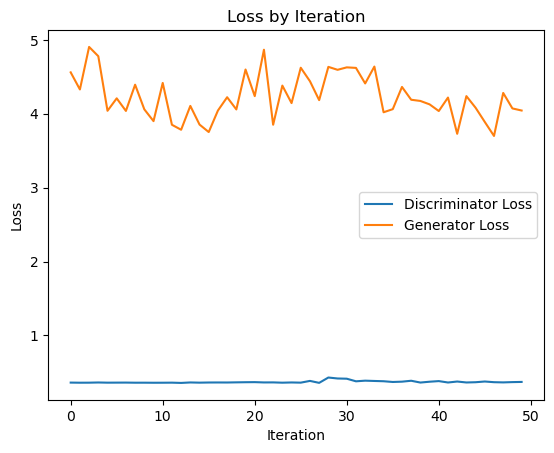

In [11]:
# plot the loss by training iteration
plt.plot(d_loss_real, label="Discriminator Loss")
plt.plot(g_loss, label="Generator Loss")
plt.title("Loss by Iteration")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.legend()
plt.show()

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load the model and make predictions on a given image
p2p_model = load_model('pix2pix_generator_model.h5')
source_img = cv2.imread(train_files[7])[:, :512]
target_img = cv2.imread(train_files[7])[:, 512:]

# Resize
IMAGE_SIZE = (512, 512)  # Set your desired image size
source_img = cv2.resize(source_img, IMAGE_SIZE)
target_img = cv2.resize(target_img, IMAGE_SIZE)

# Scale pixel values
source_img = np.array(source_img) / 127.5 - 1.
target_img = np.array(target_img) / 127.5 - 1.

# Reshape
source_img = np.expand_dims(source_img, 0)
target_img = np.expand_dims(target_img, 0)

# Make prediction, re-scale, and reshape
gen_img = p2p_model.predict(source_img)[0]
#gen_img = (gen_img + 1) / 2.0
gen_img = np.expand_dims(gen_img, 0)

# Combine and re-scale to (0, 1)
all_imgs = np.concatenate([source_img, target_img, gen_img])
all_imgs = 0.5 * all_imgs + 0.5

titles = ['Input', 'Target', 'Generated']
fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Single row with three columns

for ax, img, title in zip(axes, all_imgs, titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.show()

NameError: name 'load_model' is not defined

In [ ]:
class EvalGAN:
    def __init__(self, real_images, fake_images):
        self.real_images = preprocess_input(
            np.array([
                resize_image(i, size=(299, 299)) for i in real_images
            ])
        )
        self.fake_images = preprocess_input(
            np.array([
                resize_image(i, size=(299, 299)) for i in fake_images
            ])
        )
        self.model = InceptionV3(
            include_top=False, 
            pooling='avg', 
            input_shape=(299, 299, 3)
        )
    
    def calculate_fid(self):
        """
        Calculates the Frechet Inception Distance (FID) score.
        Implemented from: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
        """
        # calculate activations
        act1 = self.model.predict(self.real_images)
        act2 = self.model.predict(self.fake_images)
        # calculate mean and covariance statistics
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid


[real_source_images, real_target_images], _ = load_real_samples(
    batch_size=BATCH_SIZE, 
    nbr_patches=1
)

# Evaluate Pix2Pix
fake_target_images, _ = generate_fake_samples(
    generator=p2p_model, 
    real_source_image_samples=real_source_images, 
    nbr_patches=1
)

geval = EvalGAN(real_target_images, fake_target_images)
fid = geval.calculate_fid()
print("Pix2Pix FID:", fid)

1/1 [==============================] - 0s 30ms/step
